##Comparison of traditional and neuronet methods in time series prediction

Sergei Raudik, Liliya Mironova

In [0]:
import torch
import torch.nn as nn
from tqdm import tqdm_notebook

from statsmodels.tsa.holtwinters import ExponentialSmoothing

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

device = "cuda"

The Avocado dataset location: https://www.kaggle.com/neuromusic/avocado-prices

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data = pd.read_csv("drive/My Drive/avocado.csv", index_col=0)
data.head(10)

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
5,2015-11-22,1.26,55979.78,1184.27,48067.99,43.61,6683.91,6556.47,127.44,0.0,conventional,2015,Albany
6,2015-11-15,0.99,83453.76,1368.92,73672.72,93.26,8318.86,8196.81,122.05,0.0,conventional,2015,Albany
7,2015-11-08,0.98,109428.33,703.75,101815.36,80.00,6829.22,6266.85,562.37,0.0,conventional,2015,Albany
8,2015-11-01,1.02,99811.42,1022.15,87315.57,85.34,11388.36,11104.53,283.83,0.0,conventional,2015,Albany
9,2015-10-25,1.07,74338.76,842.40,64757.44,113.00,8625.92,8061.47,564.45,0.0,conventional,2015,Albany


In [0]:
data.shape

(18249, 13)

Preprocessing: conditions

In [0]:
avacado_type = "conventional"
avacado_region = 'Nashville'
data_df = data[(data['region'] == avacado_region) & (data["type"] == avacado_type)]

In [0]:
data_df.shape

(169, 13)

In [0]:
data_df = data_df[["Date", "AveragePrice"]]
data_df["Date"] = pd.to_datetime(data_df["Date"], format="%Y-%m-%d")
data_df = data_df.sort_values(by=["Date"])
data_df = data_df.set_index("Date")
data_df.head()

,AveragePrice
Date,
2015-01-04,1.00
2015-01-11,1.07
2015-01-18,1.08
2015-01-25,1.07
2015-02-01,0.94


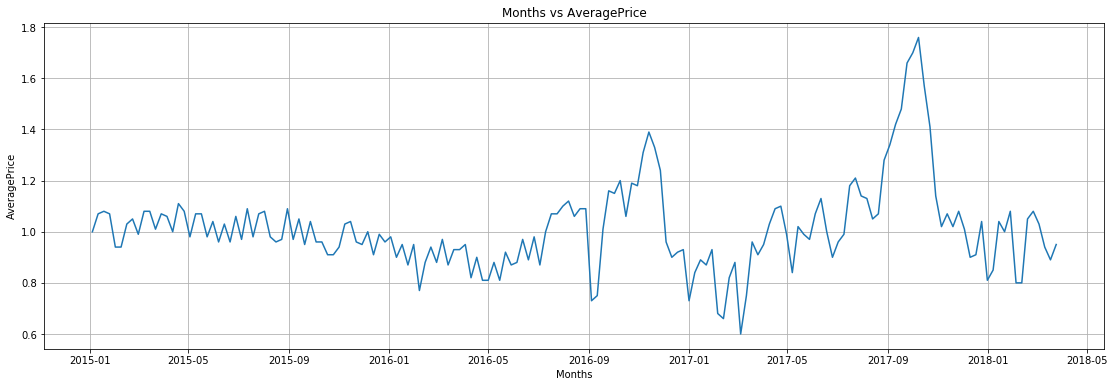

In [0]:
plt.figure(figsize=(19, 6))
plt.plot(data_df["AveragePrice"])
plt.grid(True)
plt.title('Months vs AveragePrice')
plt.ylabel('AveragePrice')
plt.xlabel('Months')
plt.show();

###1. LSTM method

Normalization: mean subtraction

In [0]:
test_data_size = 15

all_data = data_df.values.reshape(-1)

train_mean = all_data[:-test_data_size].mean()
all_data_normalized = all_data - train_mean
all_data_normalized.min(), all_data_normalized.max()

(-0.418896103896104, 0.741103896103896)

In [0]:
all_data_normalized

array([-0.0188961,  0.0511039,  0.0611039,  0.0511039, -0.0788961,
       -0.0788961,  0.0111039,  0.0311039, -0.0288961,  0.0611039,
        0.0611039, -0.0088961,  0.0511039,  0.0411039, -0.0188961,
        0.0911039,  0.0611039, -0.0388961,  0.0511039,  0.0511039,
       -0.0388961,  0.0211039, -0.0588961,  0.0111039, -0.0588961,
        0.0411039, -0.0488961,  0.0711039, -0.0388961,  0.0511039,
        0.0611039, -0.0388961, -0.0588961, -0.0488961,  0.0711039,
       -0.0488961,  0.0311039, -0.0688961,  0.0211039, -0.0588961,
       -0.0588961, -0.1088961, -0.1088961, -0.0788961,  0.0111039,
        0.0211039, -0.0588961, -0.0688961, -0.0188961, -0.1088961,
       -0.0288961, -0.0588961, -0.0388961, -0.1188961, -0.0688961,
       -0.1488961, -0.0688961, -0.2488961, -0.1388961, -0.0788961,
       -0.1388961, -0.0488961, -0.1488961, -0.0888961, -0.0888961,
       -0.0688961, -0.1988961, -0.1188961, -0.2088961, -0.2088961,
       -0.1388961, -0.2088961, -0.0988961, -0.1488961, -0.1388

In [0]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = torch.FloatTensor(input_data[i:i+tw])
        train_label = torch.FloatTensor(input_data[i+tw:i+tw+1])
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [0]:
window = 8

In [0]:
all_inout_seq = create_inout_sequences(all_data_normalized, window)

In [0]:
train_inout_seq = all_inout_seq[:-test_data_size-window]
test_inout_seq = all_inout_seq[-test_data_size:]

In [0]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=150, num_layers=3, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden_cell = None

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), -1, 1), self.hidden_cell)
        predictions = self.linear(lstm_out[-1, :, :])
        return predictions[-1]

    def init_hidden(self, batch_size, device, requires_grad=False):
        hidden = torch.zeros((self.num_layers, batch_size,
                         self.hidden_size), requires_grad=False).to(device)
        cell = torch.zeros((self.num_layers, batch_size,
                       self.hidden_size), requires_grad=False).to(device)
        return (hidden, cell)

In [0]:
def adjust_learning_rate(optimizer, epoch, lr):
  lr = lr * (0.1 ** (epoch // 100))
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

MSE loss and Adam optimizer:

In [0]:
model = LSTM().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [0]:
model

LSTM(
  (lstm): LSTM(1, 150, num_layers=3)
  (linear): Linear(in_features=150, out_features=1, bias=True)
)

Training on 300 epochs with 1e-3 learning rate

In [0]:
epochs = 300
lr = 1e-3

for i in tqdm_notebook(range(epochs)):

    adjust_learning_rate(optimizer, i, lr)

    for seq, labels in train_inout_seq:
        seq = seq.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        model.hidden_cell = model.init_hidden(1, device)

        y_pred = model(seq)

        single_loss = torch.sqrt(loss_function(y_pred, labels))
        single_loss.backward()
        optimizer.step()

    if (i+1) % 10 == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   9 loss: 0.65414363
epoch:  19 loss: 0.06366479
epoch:  29 loss: 0.15445918
epoch:  39 loss: 0.12098479
epoch:  49 loss: 0.14613569
epoch:  59 loss: 0.11652875
epoch:  69 loss: 0.00877011
epoch:  79 loss: 0.07268405
epoch:  89 loss: 0.03431702
epoch:  99 loss: 0.00845128
epoch: 109 loss: 0.00062311
epoch: 119 loss: 0.01381946
epoch: 129 loss: 0.00426275
epoch: 139 loss: 0.00032955
epoch: 149 loss: 0.00620985
epoch: 159 loss: 0.00878203
epoch: 169 loss: 0.00782698
epoch: 179 loss: 0.00723195
epoch: 189 loss: 0.00047523
epoch: 199 loss: 0.00199771
epoch: 209 loss: 0.00016534
epoch: 219 loss: 0.00016570
epoch: 229 loss: 0.00214815
epoch: 239 loss: 0.00067645
epoch: 249 loss: 0.00073475
epoch: 259 loss: 0.00122678
epoch: 269 loss: 0.00092554
epoch: 279 loss: 0.00029844
epoch: 289 loss: 0.00080806
epoch: 299 loss: 0.00165832
epoch: 299 loss: 0.0016583204


In [0]:
model.eval()

predict, groundtruth = [], []
for inp, label in train_inout_seq:
  with torch.no_grad():
      inp = inp.to(device)

      model.hidden = model.init_hidden(1, device)

      predict.append(model(inp).cpu())
      groundtruth.append(label)

In [0]:
predict = torch.as_tensor(predict) + train_mean
groundtruth = torch.as_tensor(groundtruth) + train_mean

Train loss:

In [0]:
train_loss = torch.sqrt(loss_function(predict, groundtruth))
train_loss

tensor(0.0867)

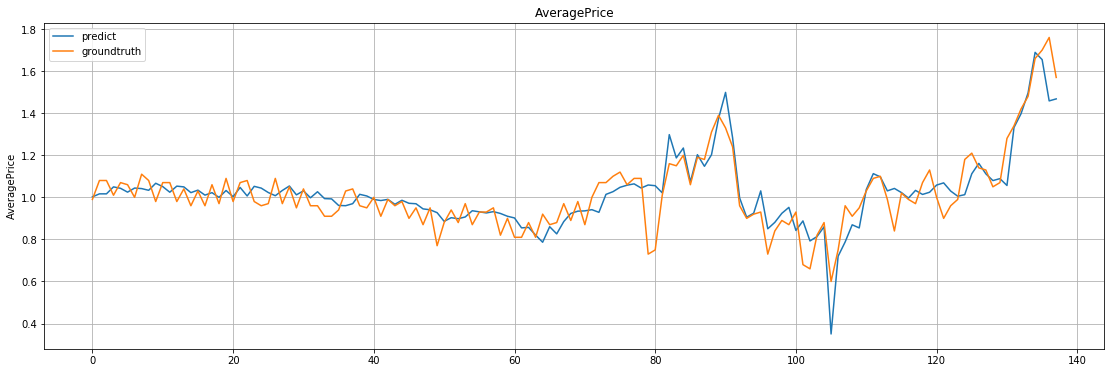

In [0]:
plt.figure(figsize=(19, 6))
plt.title('AveragePrice')
plt.ylabel('AveragePrice')
plt.grid(True)
plt.plot(predict, label="predict")
plt.plot(groundtruth, label="groundtruth")
plt.legend()
plt.show()

In [0]:
model.eval()

predict, groundtruth = [], []
for inp, label in test_inout_seq:
  with torch.no_grad():
      inp = inp.to(device)

      model.hidden = model.init_hidden(1, device)

      predict.append(model(inp).cpu())
      groundtruth.append(label)

In [0]:
predict = torch.as_tensor(predict) + train_mean
groundtruth = torch.as_tensor(groundtruth) + train_mean

Test loss:

In [0]:
test_loss = torch.sqrt(loss_function(predict, groundtruth))
test_loss

tensor(0.1337)

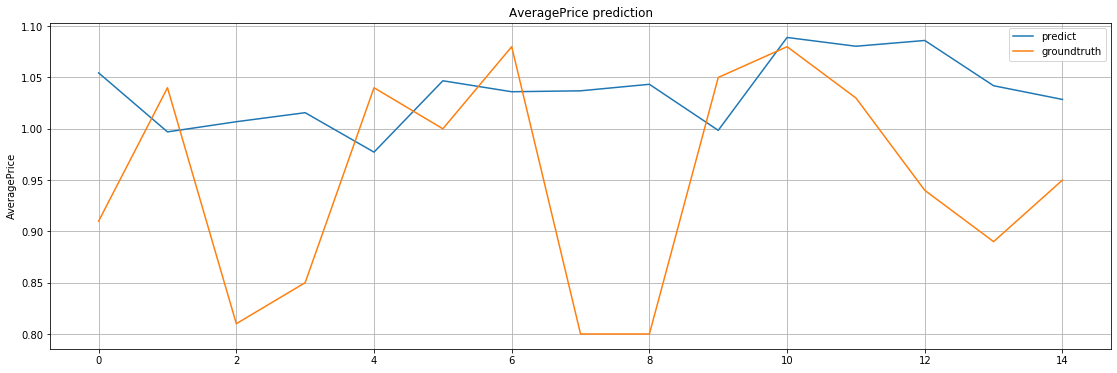

In [0]:
plt.figure(figsize=(19, 6))
plt.title('AveragePrice prediction')
plt.ylabel('AveragePrice')
plt.grid(True)
plt.plot(predict, label="predict")
plt.plot(groundtruth, label="groundtruth")
plt.legend()
plt.show()

###2. Exponential Smoothing method

There is an extended version of working with exponential smoothing: 
https://colab.research.google.com/drive/1NPWFluXmEab-oml9-2RfeKLoiHPu6S-G. 
Below is a small part only. 

In [0]:
train_data = data_df[:-test_data_size]
test_data = data_df[-test_data_size:]

In [0]:
exp_smooth = ExponentialSmoothing(train_data, trend="add", seasonal="add", seasonal_periods=52)
exp_smooth_fitted = exp_smooth.fit(remove_bias=True)
#series_fitted = exp_smooth_fitted.fittedvalues
test_values = exp_smooth_fitted.forecast(steps=15)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


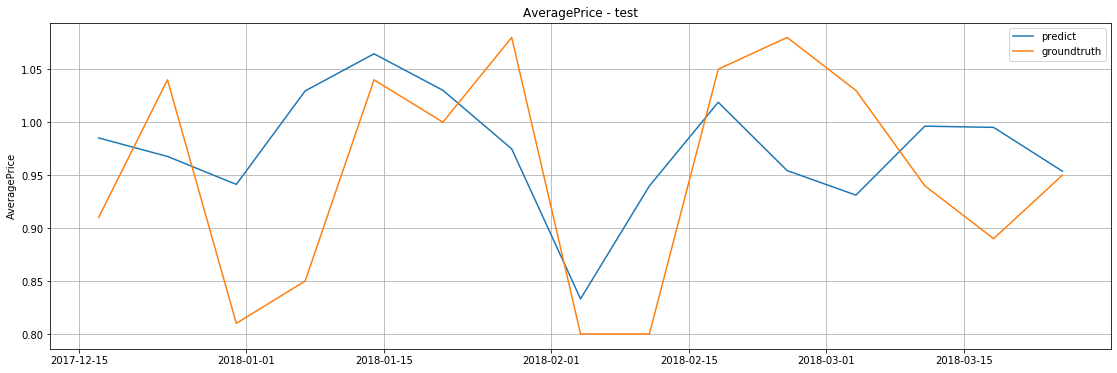

In [0]:
plt.figure(figsize=(19, 6))
plt.title('AveragePrice - test')
plt.ylabel('AveragePrice')
plt.grid(True)
plt.plot(test_values, label="predict")
plt.plot(test_values.index, groundtruth, label="groundtruth")
plt.legend()
plt.show()

Test loss:

In [0]:
test_values_t = torch.as_tensor(test_values)
test_es_loss = torch.sqrt(loss_function(test_values_t, groundtruth))
test_es_loss

tensor(0.0946)

###Conclusions

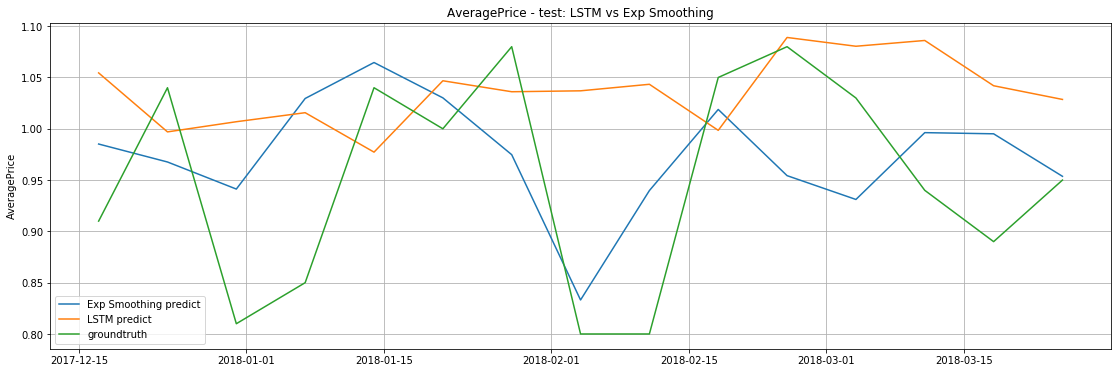

In [0]:
plt.figure(figsize=(19, 6))
plt.title('AveragePrice - test: LSTM vs Exp Smoothing')
plt.ylabel('AveragePrice')
plt.grid(True)
plt.plot(test_values, label="Exp Smoothing predict")
plt.plot(test_values.index, predict, label="LSTM predict")
plt.plot(test_values.index, groundtruth, label="groundtruth")
plt.legend()
plt.show()

So, we compared two models on time series dataset: Exponential Smoothing and LSTM. The obtained results showed that Exponential Smoothing method was more accurate: 0.0946 vs 0.1337 loss (RMSE) on the test sample.